In [1]:
from Dissects.skel import Skel
import os
from skimage import io
import numpy as np
import pandas as pd
import copy
import sys
import matplotlib.pyplot as plt
sys.setrecursionlimit(10000)

In [2]:
# directory='/home/admin-suz/Documents/testCellSeg/TestSPIM/'
# # import image
# skeleton = Skel(os.path.join(directory,'C1-20191112_SQHrfp-EcadGFP_DLG647_180degre_04-1.fits_c100.up.NDskl.a.NDskl'))

directory='/home/admin-suz/Documents/testCellSeg/Caroline/'
skeleton = Skel(os.path.join(directory,'MAX_ConcatenatedStacks-S3-corrected-T170.fits_c8.up.NDskl.a.NDskl'))

if skeleton.isValid():
    skeleton.write_vtp(os.path.join(directory, "image_original.vtp"))
else:
    raise nameError('skeleton not valid')   

reading: 14095 critical points
reading: 13990 filaments
reading: critical points data
critical points done
reading: filaments data


ValueError: could not broadcast input array from shape (2) into shape (3)

In [13]:
keep_going = True

while keep_going:
    keep_going = False
    # Récupérer les points critiques à supprimer
    cp_to_keep = []
    for c in skeleton.crit:
        if c.nfil < 2:
            cp_to_keep.append(False)
        else : 
            cp_to_keep.append(True)

    # Supprimer les points critiques
    skeleton.crit[:] = np.array(skeleton.crit)[cp_to_keep]


    fil_to_keep = []
    for f in skeleton.fil:

        if f.cp1 not in skeleton.crit:
            fil_to_keep.append(False)
            for i in range(len(skeleton.crit)):
                if f.cp2 == skeleton.crit[i]:
                    keep_going = True
                    skeleton.crit[i].filId.remove(f)
                    skeleton.crit[i].destCritId.remove(f.cp1)
                    break
            #if f.cp1.nfil == 1:
            #    skeleton.crit.remove(f.cp1)

        elif f.cp2 not in skeleton.crit:
            fil_to_keep.append(False)
            for i in range(len(skeleton.crit)):
                if f.cp1 == skeleton.crit[i]:
                    keep_going = True
                    skeleton.crit[i].filId.remove(f)
                    skeleton.crit[i].destCritId.remove(f.cp2)
                    break
            #if f.cp2.nfil == 1:
            #    skeleton.crit.remove(f.cp2)
                
        else:
            fil_to_keep.append(True)


    # Supprimer les filaments
    skeleton.fil[:] = np.array(skeleton.fil)[fil_to_keep]
        
"""
if skeleton.isValid():
    skeleton.write_vtp(os.path.join(directory, "removefil.vtp"))
else:
    raise nameError('skeleton not valid') """       

'\nif skeleton.isValid():\n    skeleton.write_vtp(os.path.join(directory, "removefil.vtp"))\nelse:\n    raise nameError(\'skeleton not valid\') '

In [20]:
n_fil = []
for c in skeleton.crit:
    n_fil.append(c.nfil)

In [21]:
for i in np.unique(n_fil):
    print(i, n_fil.count(i))

2 2606
3 325
4 31
5 4
9 1


In [70]:
x = []
y = []
z = []
for c in skeleton.crit:
    x.append(c.pos[0])
    y.append(c.pos[1])
    z.append(c.pos[2])
z = np.array(z)*0.22/0.045

In [104]:
data = []

for c in skeleton.crit:
    data.append(
        {
            "x": c.pos[0],
            "y": c.pos[1],
            "z": c.pos[2] * 0.22/0.045,
            "n_fil": c.nfil,
            "val": int(c.val),
            "pair": int(c.pair.val),
        }
    )
    
data = pd.DataFrame.from_records(data)

In [111]:
data.head()

,x,y,z,n_fil,val,pair
0,805.0,1298.0,14.666667,2,6630,3409
1,848.0,919.0,29.333333,3,5329,3018
2,860.0,937.0,29.333333,2,4027,2430
3,769.0,939.0,29.333333,2,5809,4069
4,866.0,945.0,29.333333,2,3639,2590


In [112]:
data[data["val"] == 3409]

,x,y,z,n_fil,val,pair
1384,805.0,1294.5,26.888889,2,3409,6630


In [110]:
data.groupby("pair").count()['x'].unique()

array([2, 1, 3, 4])

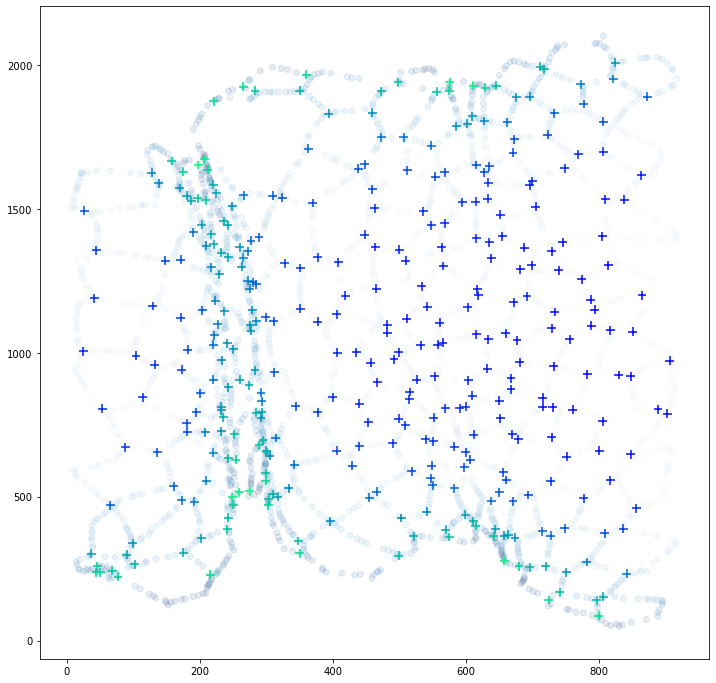

In [103]:
connected = data[data.n_fil>2]
fig, ax = plt.subplots()

ax.scatter(data.x, data.y, c=data.z, cmap='Blues', alpha=0.1)

ax.scatter(connected.x, connected.y, c=connected.z, cmap='winter', marker='+', s=80)

fig.set_size_inches(12, 12)


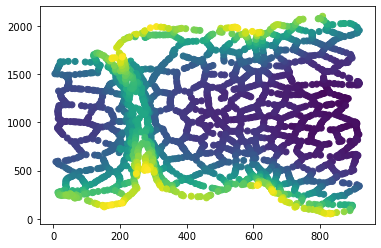

In [71]:
plt.scatter(x,y, c=z, cmap='viridis')

In [119]:
import ipyvolume as ipv
from matplotlib import cm

cmap = cm.get_cmap("viridis")
colors = cmap((z-z.min())/(z.max()-z.min()))

ipv.clear()
ipv.scatter(x=np.array(x)*10, y=np.array(y)*10, z=z*10, size=1, color=colors, marker='circle_2d')
ipv.squarelim()
ipv.show()

In [6]:
## ATTENTION le chargement de l'image peut etre long...
#Original image stack
img0 = io.imread(os.path.join(directory, "MAX_Concatenated Stacks-S3-corrected-T170.tif"))

img_output = img0.copy()

In [14]:
img_output = np.where(img_output>0, 0, img_output) 
for f in skeleton.fil:
    for p in f.points: 
        img_output[int(p[1])][int(p[0])]=65000
io.imsave(os.path.join(directory, 'output.tif'), img_output)        

In [15]:
img_output = np.where(img_output>0, 0, img_output) 

w = 1
for f in skeleton.fil:
    for p in f.points: 
        for y in range(int(p[1])-w,int(p[1])+w):
            for x in range(int(p[0])-w,int(p[0])+w):
                try:
                    img_output[y][x]=65000
                except:
                    pass

io.imsave(os.path.join(directory, 'output3.tif'), img_output)        

In [ ]:
# Trimage sur la field value moyenne d'un segment

threshold = 1500
new_fil = []

for i,f in enumerate(skeleton.fil):
    field_value = 0
    for d in f.data :
        field_value+=d[0]
        
    field_value/=f.nsamp
    
    if field_value>threshold:
        new_fil.append(f)

#liste des points critiques
new_crit=[]
for i,f in enumerate(new_fil):
    new_crit.append(f.cp2)
    new_crit.append(f.cp1)
    

In [ ]:
new_skeleton = copy.deepcopy(skeleton)
new_skeleton.fil = new_fil
new_skeleton.crit = new_crit

# liste de point critique unique
i = 0
while i<len(new_skeleton.crit):
    if new_skeleton.crit.index(new_skeleton.crit[i]) != i:
        del new_skeleton.crit[new_skeleton.crit.index(new_skeleton.crit[i])]
    else:
        i+=1
    
if new_skeleton.isValid():
    new_skeleton.write_vtp(os.path.join(directory, "trimer_"+str(threshold)+".vtp"))
else:
    raise nameError('skeleton not valid')
skeleton = copy.deepcopy(new_skeleton)  
save_skeleton = copy.deepcopy(skeleton)

In [ ]:
# Creation d'un sheet

# Creation d'un tableau de vertex
vert_df= pd.DataFrame(columns=['x', 'y', 'z', 'pos'])

i=0
for c in skeleton.crit:
    if c.typ == 3 and c.nfil>2:
        vert_df.loc[i] = [c.pos[0], c.pos[1], c.pos[2], c]
        i+=1

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=vert_df.x,
    y=vert_df.y,
    z=vert_df.z,
    mode='markers',
    marker=dict(
        size=1,
        color=vert_df.z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
tmp = []
for c in skeleton.crit:
    tmp.append(c.skeleton.)

In [32]:
# test import czi file and convert to fits
from czifile import CziFile
from skimage import io
from astropy.io import fits

with CziFile('/home/admin-suz/Documents/testCellSeg/test.czi') as czi:
    image_arrays = czi.asarray()
    
hdu = fits.PrimaryHDU(image_arrays)
hdu.writeto('20170531_emb_PHmch1_Melanie_bin2_z70-124_croped.fits')


In [31]:
image_arrays.shape

(1, 1, 4, 1, 108, 512, 512, 1)

In [36]:
import czifile

In [37]:
?czifile

## "Nettoyage du tissu"

In [ ]:
skeleton = copy.deepcopy(save_skeleton)

In [ ]:
keep_going = True

while keep_going:
    keep_going = False
    # Récupérer les points critiques à supprimer
    cp_to_keep = []
    for c in skeleton.crit:
        if c.nfil < 2:
            cp_to_keep.append(False)
        else : 
            cp_to_keep.append(True)

    # Supprimer les points critiques
    skeleton.crit[:] = np.array(skeleton.crit)[cp_to_keep]


    fil_to_keep = []
    for f in skeleton.fil:

        if f.cp1 not in skeleton.crit:
            fil_to_keep.append(False)
            for i in range(len(skeleton.crit)):
                if f.cp2 == skeleton.crit[i]:
                    keep_going = True
                    skeleton.crit[i].filId.remove(f)
                    skeleton.crit[i].destCritId.remove(f.cp1)
                    break
            #if f.cp1.nfil == 1:
            #    skeleton.crit.remove(f.cp1)

        elif f.cp2 not in skeleton.crit:
            fil_to_keep.append(False)
            for i in range(len(skeleton.crit)):
                if f.cp1 == skeleton.crit[i]:
                    keep_going = True
                    skeleton.crit[i].filId.remove(f)
                    skeleton.crit[i].destCritId.remove(f.cp2)
                    break
            #if f.cp2.nfil == 1:
            #    skeleton.crit.remove(f.cp2)
                
        else:
            fil_to_keep.append(True)


    # Supprimer les filaments
    skeleton.fil[:] = np.array(skeleton.fil)[fil_to_keep]
        

if skeleton.isValid():
    skeleton.write_vtp(os.path.join(directory, "trimer_"+str(threshold)+"removefil"+".vtp"))
else:
    raise nameError('skeleton not valid')        

In [ ]:
skeleton = copy.deepcopy(new_skeleton)
continu=1
cpt=0
while continu:
    cpt+=1
    continu=0
    for i,f in enumerate(skeleton.fil):
        if (f.cp2.nfil < 2) or (f.cp1.nfil < 2):
            continu=1
            break
        
    new_fil = []
    for i,f in enumerate(skeleton.fil):
        if (f.cp2.nfil > 2) :
            new_fil.append(f)
        
    for f in new_fil:
        if f not in skeleton.fil : 
            if f.cp2.nfil == 1:
                for i in range (len(skeleton.crit)):
                    if skeleton.crit[i] == f.cp2:
                        skeleton.crit[i].unconnect_fil(0)
            elif f.cp1.nfil == 1:
                for i in range (len(skeleton.crit)):
                    if skeleton.crit[i] == f.cp1:
                        skeleton.crit[i].unconnect_fil(0)
                        

    new_crit=[]
    for i,f in enumerate(new_fil):
        new_crit.append(f.cp2)
        new_crit.append(f.cp1)

    new_skeleton = copy.deepcopy(skeleton)
    new_skeleton.fil = new_fil
    new_skeleton.crit = new_crit

    if new_skeleton.isValid():
        new_skeleton.write_vtp(os.path.join(directory, "trimer_"+str(threshold)+"removefil"+str(cpt)+".vtp"))
    else:
        raise nameError('skeleton not valid')

In [ ]:
skeleton.write_vtp(os.path.join(directory, "trimer_"+str(threshold)+"removefil2"+".vtp"))

In [ ]:
l =[] 
for c in new_skeleton.crit:
    l.append(c.typ)
np.unique(l)

In [ ]:
skeleton = copy.deepcopy(new_skeleton)
continu=1
while continu:
    cpt+=1
    continu=0
    
    skeleton = copy.deepcopy(new_skeleton)
    for i,f in enumerate(skeleton.fil):
        if (f.cp2.boundary ==1) or (f.cp1.boundary==1):
            continu=1
            break
        
    new_fil = []
    for i,f in enumerate(skeleton.fil):
        if (f.cp2.boundary==0) and (f.cp1.boundary==0):
            new_fil.append(f)

            new_crit=[]
    for i,f in enumerate(new_fil):
        new_crit.append(f.cp2)
        new_crit.append(f.cp1)

    new_skeleton = copy.deepcopy(skeleton)
    new_skeleton.fil = new_fil
    new_skeleton.crit = new_crit

    if new_skeleton.isValid():
        new_skeleton.write_vtp(os.path.join(directory, "trimer_"+str(threshold)+"removefil"+".vtp"))
    else:
        raise nameError('skeleton not valid')

In [ ]:
skeleton = copy.deepcopy(new_skeleton)

new_fil = []
for i,f in enumerate(skeleton.fil):
    if f.len <30 :
        new_fil.append(f)

new_crit=[]
for i,f in enumerate(new_fil):
    new_crit.append(f.cp2)
    new_crit.append(f.cp1)

new_skeleton = copy.deepcopy(skeleton)
new_skeleton.fil = new_fil
new_skeleton.crit = new_crit

if new_skeleton.isValid():
    new_skeleton.write_vtp(os.path.join(directory, "trimer_"+str(threshold)+"removefil"+".vtp"))
else:
    raise nameError('skeleton not valid')
    
skeleton = copy.deepcopy(new_skeleton)

## Liaison des fils entre 2 points critiques

In [ ]:
crit_3f = []
for c in skeleton.crit:
    if c.nfil == 3:
        crit_3f.append(c)

In [ ]:
len(crit_3f)

In [ ]:
skeleton.fil[0].points

In [ ]:
print(skeleton.fil[0].cp1.pos)
print(skeleton.fil[0].cp2.pos)


In [ ]:
continu=1
cpt = 0
while continu:
    cpt+=1
    continu=0
    skeleton = copy.deepcopy(new_skeleton)
    for i,f in enumerate(skeleton.fil):
        if f.cp2.nfil < 2:
            continu=1
            break        
    new_fil = []
    for i,f in enumerate(skeleton.fil):
        if f.cp2.nfil >= 2:
            new_fil.append(f)

            new_crit=[]
    for i,f in enumerate(new_fil):
        new_crit.append(f.cp2)
        new_crit.append(f.cp1)

    new_skeleton = copy.deepcopy(skeleton)
    new_skeleton.fil = new_fil
    new_skeleton.crit = new_crit

    if new_skeleton.isValid():
        new_skeleton.write_vtp(os.path.join(directory, "trimer_"+str(threshold)+"removefil"+".vtp"))
    else:
        raise nameError('skeleton not valid')

In [ ]:
new_skeleton.fil_data_name

In [ ]:
skeleton.fil[0].data

In [ ]:
## Creation d'un nouveau skelete 
## sauvegarde d'un nouveau skeleton

# liste des filaments
fil2=[]
for i,f in enumerate(skeleton.fil):
    if f.cp2.nfil >2:
        fil2.append(f)
        
# nombre de point critique au départ, nombre de point critique ayant plus de trois filaments
#print(len(skeleton.crit), len(crit_nfil3))

#liste des points critiques
crit2=[]
for i,f in enumerate(fil2):
    crit2.append(f.cp2)
    crit2.append(f.cp1)
    

    
new_skeleton.crit=crit2
new_skeleton.fil=fil2


new_skeleton.isValid()

new_skeleton.write_vtp("filename.vtp")




In [ ]:
skeleton.fil_data_name
skeleton.fil[0].data
# liste des colonnes du tableau des points critiques
skeleton.crit_data_name

